In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import albumentations as albu
import cv2
import my_lib
import tensorflow as tf
import gc
import pickle
from keras.callbacks import CSVLogger
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score, precision_score, recall_score, accuracy_score, f1_score
from ModelArchitecture.DiceLoss import dice_metric_loss
from ModelArchitecture import DUCK_Net

In [2]:
# First things first, set up our parameters

img_size = 128
learning_rate = 1e-4 # Controls how fast the loss goes down
filters = 17 # Number of filters
seed_value = 37
batch_size = 16 # parallel computes
optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate) # the optimizer to use

ct = datetime.now()

model_type = "DuckNet"

progress_path = 'ProgressFull/' + 'progress_csv_' + model_type + '_filters_' + str(filters) +  '_' + str(ct).split('.')[0].replace(':','-') + '.csv'
progressfull_path = 'ProgressFull/' + 'progress_' + model_type + '_filters_' + str(filters) + '_' + str(ct).split('.')[0].replace(':','-') + '.txt'
plot_path = 'ProgressFull/' + 'progress_plot_' + model_type + '_filters_' + str(filters) + '_' + str(ct).split('.')[0].replace(':','-') + '.png'
model_path = 'ModelSaveTensorFlow/' + model_type + '_filters_' + str(filters) + '_' + str(ct).split('.')[0].replace(':','-')

EPOCHS = 10
min_loss_for_saving = 0.2

In [3]:
# Load the data
data_root = '../data/photos/'
data_paths = [data_root + x for x in os.listdir(data_root) if x.find('.png') > 0]
mask_root = '../data/Ground Truth Elastin/'
mask_paths = [mask_root + x for x in os.listdir(mask_root) if x.find('.png') > 0]

X = []
Y = []

for x, y in zip(data_paths, mask_paths):
    aligned = my_lib.align_datum(x, y, size=img_size)
    for idx in range(len(aligned['i'])):
        filename = aligned['path'][idx].split('/')[-1].split('.')[0]
        subdata_path = '../data/processed/' + filename + '_' + str(aligned['i'][idx]) + '-' + str(aligned['j'][idx]) + '.png'
        submask_path = '../data/processed/gt_' + filename + '_' + str(aligned['i'][idx]) + '-' + str(aligned['j'][idx]) + '.png'
        
        X.append(subdata_path)
        Y.append(submask_path)
        
        cv2.imwrite(subdata_path, aligned['data'][idx] * 255)
        cv2.imwrite(submask_path, aligned['mask'][idx] * 255)
        
        
print(len(X), len(Y))
del aligned

17600 17600


In [4]:
x_train, x_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state = seed_value)
x_valid, x_test, y_valid, y_test = train_test_split(x_valid, y_valid, test_size=0.5, shuffle=True, random_state=seed_value)

In [5]:
model = DUCK_Net.create_model(img_height=img_size, img_width=img_size, input_chanels=1, out_classes=1, starting_filters=filters)

Starting DUCK-Net


In [6]:
model.compile(optimizer=optimizer, loss=dice_metric_loss)

In [7]:
training_batch_gen = my_lib.My_Custom_Generator(x_train, y_train, batch_size=batch_size)
val_batch_gen = my_lib.My_Custom_Generator(x_valid, y_valid, batch_size=batch_size)
test_batch_gen = my_lib.My_Custom_Generator(x_test, y_test, batch_size=batch_size, augmentations=False)

In [8]:
model.fit(x = training_batch_gen,
          steps_per_epoch = len(training_batch_gen),
          epochs = EPOCHS,
          verbose=1,
          validation_data=val_batch_gen,
          validation_steps = len(val_batch_gen))

Epoch 1/10
880/880 [==============================] - 443s 503ms/step - loss: 0.9941 - val_loss: 0.9925
Epoch 2/10
880/880 [==============================] - 435s 495ms/step - loss: 0.9902 - val_loss: 0.9875
Epoch 3/10
880/880 [==============================] - 547s 622ms/step - loss: 0.9868 - val_loss: 0.9844
Epoch 4/10
880/880 [==============================] - 468s 532ms/step - loss: 0.9840 - val_loss: 0.9758
Epoch 5/10
880/880 [==============================] - 458s 520ms/step - loss: 0.9782 - val_loss: 0.9746
Epoch 6/10
880/880 [==============================] - 499s 567ms/step - loss: 0.9717 - val_loss: 0.9673
Epoch 7/10
880/880 [==============================] - 484s 550ms/step - loss: 0.9624 - val_loss: 0.9583
Epoch 8/10
880/880 [==============================] - 480s 545ms/step - loss: 0.9519 - val_loss: 0.9512
Epoch 9/10
880/880 [==============================] - 481s 546ms/step - loss: 0.9394 - val_loss: 0.9311
Epoch 10/10
880/880 [==============================] - 484s 549m

In [12]:
model.save('./ModelSaveTensorFlow/my_model')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./ModelSaveTensorFlow/my_model\assets


In [3]:
# load the model from memory
model = tf.keras.models.load_model('./ModelSaveTensorFlow/my_model', custom_objects={'dice_metric_loss': dice_metric_loss})

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 1)  4           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 128, 17) 170         batch_normalization[0][0]        
__________________________________________________________________________________________________
batch_normalization_15 (BatchNo (None, 128, 128, 17) 68          conv2d_20[0][0]                  
_______________________________________________________________________________________

In [10]:
os.listdir('../data/photos/')

['535_6_8.png',
 '535_8_2.png',
 '535_9_5.png',
 '536_2_2.png',
 '536_5_1.png',
 '536_8_3.png',
 '536_9_6.png',
 '536_9_7.png',
 '537_5_2.png',
 '537_7_11.png',
 'C-8.png']

In [4]:
def build_prediction(model, input_file, color=False):
    # read in the image
    image = cv2.imread(input_file)
    if not color:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    images = my_lib.shatter_img(image, size=img_size)
    rows = len(images)
    cols = len(images[0])
    X = []
    for i in range(rows):
        for j in range(cols):
            X.append(images[i][j] / 255)
    X = np.array(X)
    Y = model.predict(X)
    
    # reconstruct image
    big_img = []
    k = 0
    for i in range(rows):
        temp = []
        for j in range(cols):
            temp.append(Y[k])
            k += 1
        big_img.append(temp)
    
    big_img = my_lib.stitch_img_grid(big_img)
    
    return big_img

In [5]:
Y = build_prediction(model, '../data/photos/535_6_8.png')

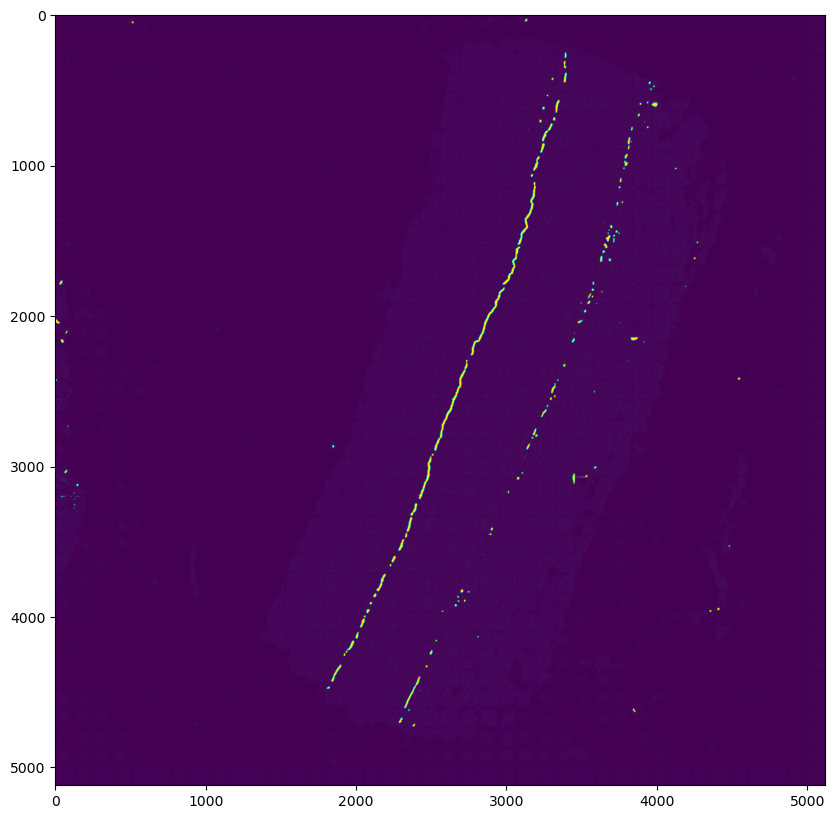

In [9]:
plt.figure(figsize=(10,10))
plt.imshow(Y * 255)
plt.show()